### **Importing  the Librairies**

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [3]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.14.0
Eager mode:  True
Hub version:  0.16.0.dev
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


### Load the data




In [4]:
local_zip_file = r"C:\Users\dhyan\Downloads\rice-leaf-diseases-detection-master\rice-leaf-diseases-detection-master\rice-leaf.zip"

# Unzip the file
import zipfile

with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')


### Prepare training and validation  dataset


In [5]:
data_dir = os.path.join('/content', 'rice')  # Removed leading slash
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [6]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [7]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content\rice\train : 157files
total images for validation : /content\rice\validation : 84files


### Label mapping


In [8]:
import zipfile

zip_file_path = r"C:\Users\dhyan\Downloads\rice-leaf-diseases-detection-master.zip" 

# Specify the directory where you want to extract the contents
destination_dir = r"C:\Users\dhyan\Downloads"  

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)


In [9]:
import json

with open("C:\\Users\\dhyan\\Downloads\\rice-leaf-diseases-detection-master\\classes.json", 'r') as f: 
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

print(classes)


['Bacterial_leaf_blight', 'blast', 'brownspot']


In [10]:
print('Number of classes:',len(classes))

Number of classes: 3




```
# This is formatted as code
```

###Select the Hub/TF2 module to use

In [11]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing




In [12]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


###Build the model


In [13]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [14]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [15]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 22853411 (87.18 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 21802784 

### Specify Loss Function and Optimizer

In [16]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model


In [17]:

EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

C:\Users\dhyan\AppData\Local\Temp\ipykernel_23628\1338723247.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
2/2 [==============================] - 32s 13s/step - loss: 1.3998 - accuracy: 0.4731 - val_loss: 3.9938 - val_accuracy: 0.0000e+00
Epoch 2/30
2/2 [==============================] - 26s 17s/step - loss: 1.3770 - accuracy: 0.5938 - val_loss: 1.0027 - val_accuracy: 0.4844
Epoch 3/30
2/2 [==============================] - 31s 20s/step - loss: 0.7733 - accuracy: 0.5938 - val_loss: 0.9217 - val_accuracy: 0.6719
Epoch 4/30
2/2 [==============================] - 27s 15s/step - loss: 0.6594 - accuracy: 0.7849 - val_loss: 1.3366 - val_accuracy: 0.6562
Epoch 5/30
2/2 [==============================] - 27s 15s/step - loss: 0.6511 - accuracy: 0.7957 - val_loss: 1.2642 - val_accuracy: 0.5938
Epoch 6/30
2/2 [==============================] - 28s 15s/step - loss: 0.4733 - accuracy: 0.8172 - val_loss: 1.0521 - val_accuracy: 0.5625
Epoch 7/30
2/2 [==============================] - 34s 18s/step - loss: 0.3570 - accuracy: 0.8387 - val_loss: 0.9125 - val_accuracy: 0.6094
Epoch 8/30
2/2 [=======

###Check Performance


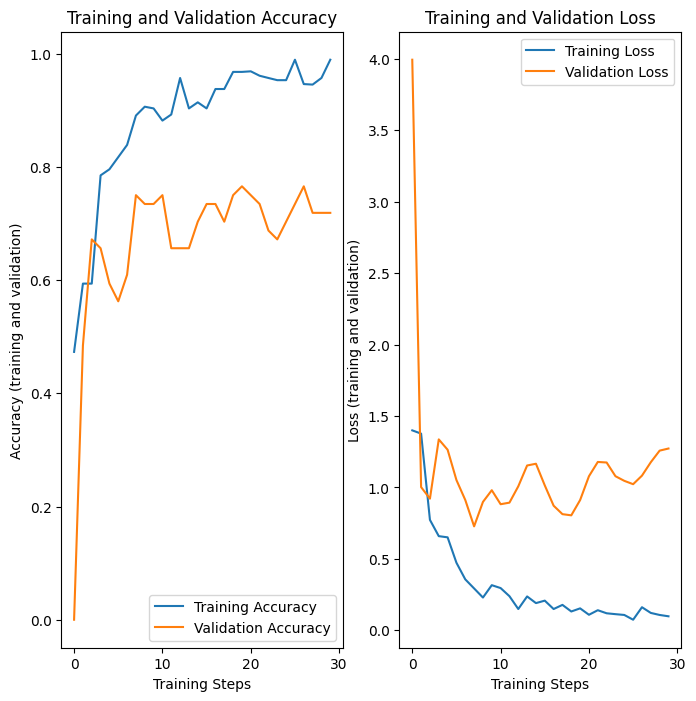

In [18]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test


In [19]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_003.jpg
1/1 [==============================] - 1s 1s/step
PREDICTED: class: blast, confidence: 0.401314


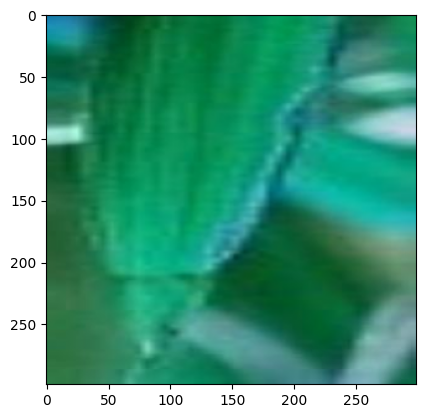

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_024.PNG
1/1 [==============================] - 0s 178ms/step
PREDICTED: class: blast, confidence: 0.532309


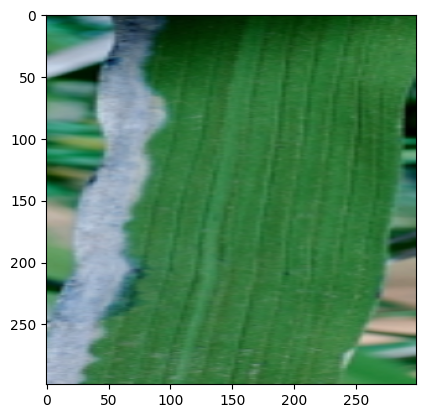

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight\blight_rotated_014.png
1/1 [==============================] - 0s 172ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.535167


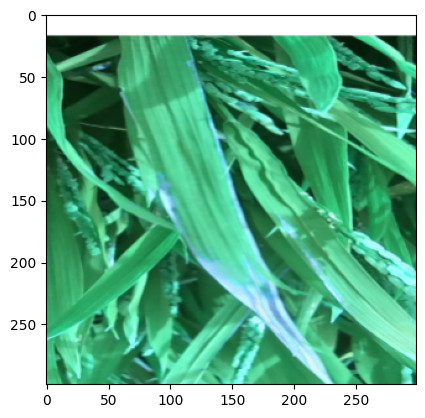

<Figure size 640x480 with 0 Axes>

SOURCE: class: brownspot, file: brownspot\brownspot_rotated_014.jpg
1/1 [==============================] - 0s 182ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.920625


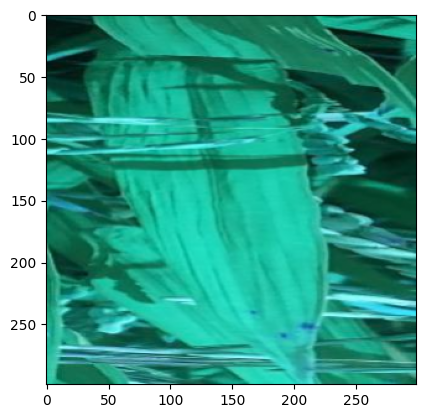

<Figure size 640x480 with 0 Axes>

SOURCE: class: blast, file: blast\blast_rotated_001.jpg
1/1 [==============================] - 0s 186ms/step
PREDICTED: class: brownspot, confidence: 0.996896


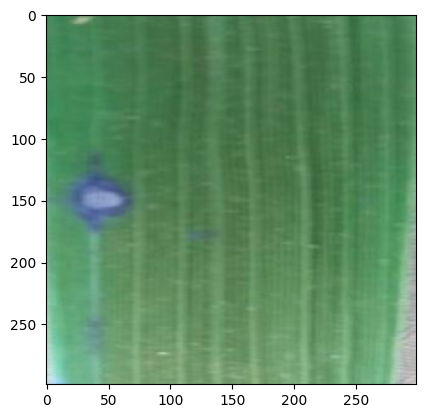

<Figure size 640x480 with 0 Axes>

In [20]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [23]:
import requests
import json

# Function to fetch weather data
def get_weather_data(api_key, latitude, longitude):
    base_url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "lat": latitude,
        "lon": longitude,
        "appid": api_key,
    }

    response = requests.get(base_url, params=params)
    weather_data = response.json()
    
    if response.status_code == 200:
        # Extract relevant weather information (e.g., temperature, humidity, rainfall)
        temperature = weather_data["main"]["temp"]
        humidity = weather_data["main"]["humidity"]
        # You may need to access other weather parameters based on your requirements
        
        # Return the weather data
        return {
            "temperature": temperature,
            "humidity": humidity,
            # Include additional weather parameters as needed
        }
    else:
        print("Failed to retrieve weather data.")
        return None

# Specify the location (latitude and longitude) of Chennai
latitude = 13.0827  # Latitude for Chennai
longitude = 80.2707  # Longitude for Chennai

# Replace "YOUR_API_KEY" with your actual OpenWeatherMap API key
api_key = "075d645f576299fc5e0b6ff3ca7ad105"

# Call the function to get weather data
weather_data = get_weather_data(api_key, latitude, longitude)

# Now, you have weather data in the "weather_data" variable

# Save the weather data to a JSON file
with open("weather_data.json", "w") as json_file:
    json.dump(weather_data, json_file)



## CONCLUSION
We will try to server data to messenger and android